Objective: To run PLS-DA analysis on Vectra Halo Object data with Spatial Neighbors defined as Features 

Input: Object data with neighborhood profiles as a part of the dataframe.

Output: PLS-DA plots, VIP scores, confusion matrices, ROC curve, permutation testing results, under-sampling results.


Date most recent version: 11/4/24

In [ ]:
pip install pyopls

/tmp/ipykernel_623168/4059074071.py:20: DtypeWarning: Columns (9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,30,31,32,33,34,35,36,37,38,55,56,57,58) have mixed types. Specify dtype option on import or set low_memory=False.
  neighborData = pd.read_csv(location)


1985863
0          1
1          1
2          1
3          1
4          1
          ..
1985858    1
1985859    1
1985860    1
1985861    1
1985862    1
Name: ClassifierLabel_bin, Length: 1985863, dtype: object
['PanCyto+MHCI+_tumor', 'PanCyto+MHCI+_stroma', 'PanCyto+MHCI-_tumor', 'PanCyto+MHCI-_stroma', 'CD8-CD3+IFNy+_tumor', 'CD8-CD3+IFNy+_stroma', 'CD8-CD3+IFNy-_tumor', 'CD8-CD3+IFNy-_stroma', 'CD8+CD3+IFNy+_tumor', 'CD8+CD3+IFNy+_stroma', 'CD8+CD3+IFNy-_tumor', 'CD8+CD3+IFNy-_stroma', 'CD56+CD3-IFNy+_tumor', 'CD56+CD3-IFNy+_stroma', 'CD56+CD3-IFNy-_tumor', 'CD56+CD3-IFNy-_stroma']
['PanCyto+MHCI+_tumor Neighbors', 'PanCyto+MHCI+_stroma Neighbors', 'PanCyto+MHCI-_tumor Neighbors', 'PanCyto+MHCI-_stroma Neighbors', 'CD8-CD3+IFNy+_tumor Neighbors', 'CD8-CD3+IFNy+_stroma Neighbors', 'CD8-CD3+IFNy-_tumor Neighbors', 'CD8-CD3+IFNy-_stroma Neighbors', 'CD8+CD3+IFNy+_tumor Neighbors', 'CD8+CD3+IFNy+_stroma Neighbors', 'CD8+CD3+IFNy-_tumor Neighbors', 'CD8+CD3+IFNy-_stroma Neighbors', 'CD56+C

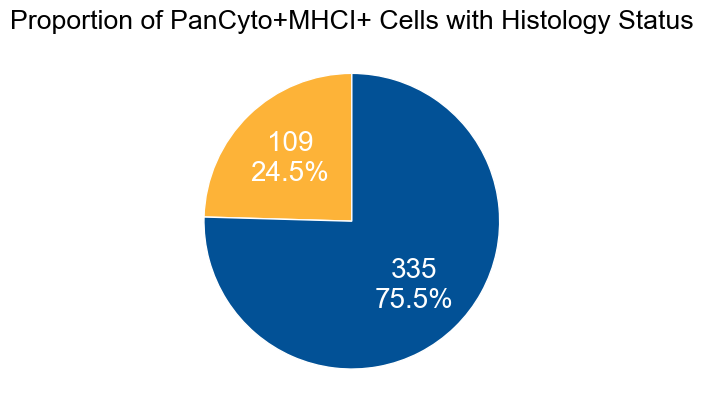

y 0      1
1      1
2      1
3      1
4      1
      ..
439    0
440    0
441    0
442    0
443    0
Name: Histology, Length: 444, dtype: int64
                                         ImageLocation  PanCyto+MHCI+_tumor  \
34   E:\Brown 3.21.19\IMAGES 3.25.19\MAD15-517_[419...                 76.0   
188  E:\Brown 4.25.19\Unmixed Images 4.29.19\MAD15-...                 35.0   
132  E:\Brown 3.21.19\IMAGES 3.25.19\MAD17-205_[509...                  0.0   
282  E:\Brown 4.25.19\Unmixed Images 4.29.19\MAD17-...                515.0   
66   E:\Brown 3.21.19\IMAGES 3.25.19\MAD15-690_[499...                120.0   
..                                                 ...                  ...   
386  E:\Brown 4.25.19\Unmixed Images 4.29.19\MAD17-...                314.0   
387  E:\Brown 4.25.19\Unmixed Images 4.29.19\MAD17-...               1190.0   
388  E:\Brown 4.25.19\Unmixed Images 4.29.19\MAD17-...                216.0   
389  E:\Brown 4.25.19\Unmixed Images 4.29.19\MAD17-...            

In [6]:
# Importing required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import re
import glob
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import scipy.io
from pyopls import OPLS
from imblearn.under_sampling import RandomUnderSampler

# File paths
neighbor_data_path = '/scratch/kag7stn/Brown 11-12-23 Neighbor Finding Codes/5-9-24-BrownData_neighbors_multiradius_merged_scc_adeno.csv'
stage_data_path = '/scratch/kag7stn/Brown_NSCLC_StageData.xlsx'

# Analysis settings
study_name = 'Brown_NSCLC_allradius_30um'
date = '4-21-24'
stagesort, histologysort, regionsort = False, False, False
undersampled, orthogonalized, conditionalNeighbor, multiradius = True, True, False, True

# Loading and preparing data
neighborData = pd.read_csv(neighbor_data_path).iloc[:-100]  # Exclude last 100 rows
stageData = pd.read_excel(stage_data_path)
print(f"Initial neighbor data length: {len(neighborData)}")

# Renaming columns in stage data
stageData = stageData.rename(columns={'Patient': 'PatientID', 'Differntiation': 'Differentiation'})

# Define cell types for analysis
cellTypes = ['PanCyto+MHCI+', 'PanCyto+MHCI-', 'CD8-CD3+IFNy+', 'CD8-CD3+IFNy-', 'CD8+CD3+IFNy+', 'CD8+CD3+IFNy-', 'CD56+CD3-IFNy+', 'CD56+CD3-IFNy-']
cellTypes_classifier = [f"{cell}_tumor" for cell in cellTypes] + [f"{cell}_stroma" for cell in cellTypes]
cellNeighbors = [f"{cell} Neighbors" for cell in cellTypes_classifier]

# Handling multiradius columns
if multiradius:
    cellNeighbors = [f"{col}_30um" for col in cellNeighbors] + [f"{col}_200um" for col in cellNeighbors]

# Merging metadata
neighborData = neighborData.merge(stageData[['PatientID', 'Stage', 'Differentiation', 'Histologic Type']], on='PatientID', how='left')

# Helper functions for data labeling
def get_advanced_stage(stage):
    stage = str(stage)
    if stage.startswith("G2") or stage.startswith("G3") or stage.startswith("G4"):
        return 1
    elif stage.startswith("G1"):
        return 0
    return None

def get_histology(stage):
    stage = str(stage)
    if any(sub in stage for sub in ["Keratinizing", "Non", "Squam"]):
        return 1
    elif any(sub in stage for sub in ["Adenocarcinoma", "Lepidic", "Acinar", "Papillary", "Mucinous"]):
        return 0
    return None

# Applying classification
neighborData['AdvancedStage'] = neighborData["Stage"].apply(get_advanced_stage)
neighborData['Histology'] = neighborData['Histologic Type'].apply(get_histology)
neighborData = neighborData.dropna(subset=['AdvancedStage', 'Histology'])

# Filtering data by analysis settings
if stagesort:
    neighborData = neighborData[neighborData['AdvancedStage'] == 1]
if histologysort:
    neighborData = neighborData[neighborData['Histology'] == 0]
if regionsort:
    neighborData = neighborData[neighborData['ClassifierLabel_bin'] == 0]

# Defining analysis parameters
centerCell = ['PanCyto+MHCI+']
classifier = ['Histology']
print(f"cellNeighbors: {cellNeighbors}")
print(f"neighborData columns: {neighborData.columns}")

# Isolate center cells
centerCells = neighborData[neighborData[centerCell[0]] == 1]
print(f"Abundance of center cells: {len(centerCells)}")

# Grouping and merging histology data
grouped_df = neighborData.groupby('ImageLocation')[cellTypes].sum().reset_index()
histology_mapping = neighborData.groupby('ImageLocation')['Histology'].first().reset_index()
xData = pd.merge(grouped_df, histology_mapping, on='ImageLocation')

# Plotting proportions of classifier labels
proportions = [
    len(xData[xData[classifier[0]] == 1]) / len(xData),
    len(xData[xData[classifier[0]] == 0]) / len(xData)
]
colors = [(253/255, 179/255, 56/255), (2/255, 81/255, 150/255)]
plt.pie(proportions, colors=colors, startangle=90, 
        autopct=lambda p: '{:.0f}\n{:.1f}%'.format(p * len(xData) / 100, p),
        textprops={'color': 'white', 'fontsize': 20})
plt.title(f"Proportion of {centerCell[0]} Cells with {classifier[0]} Status")
plt.savefig(f"{date}{study_name}{centerCell[0]}{classifier[0]}_proportions_piechart_labeled.pdf", format='pdf', bbox_inches='tight')
plt.show()

# Undersampling to balance classes
X, y = xData, xData[classifier[0]].astype(int)
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)
print(f"Resampled data: {len(X_resampled)} rows")

# Grouping slide counts and histology info by PatientID
slide_counts = neighborData.groupby('PatientID')['ImageLocation'].nunique().reset_index()
histology_info = neighborData.groupby('PatientID')['Histology'].first().reset_index()
slide_counts = pd.merge(slide_counts, histology_info, on='PatientID')
slide_counts.columns = ['PatientID', 'NumSlides', 'Histology']
print(slide_counts)

# Saving the modified xData to a CSV file
xData.to_csv("/scratch/kag7stn/5-9-24-BrownData_neighbors_multiradius_merged.csv")

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Bar plot for unique PatientIDs
plt.figure(figsize=(10, 6))
sns.barplot(x=unique_patient_counts.index, y=unique_patient_counts.values, palette="viridis")
plt.title("Number of Unique PatientIDs within Each Histology Group")
plt.xlabel("Histology Group")
plt.ylabel("Number of Unique PatientIDs")
plt.show()

# Bar plot for unique ImageLocation names
plt.figure(figsize=(10, 6))
sns.barplot(x=unique_image_location_counts.index, y=unique_image_location_counts.values, palette="viridis")
plt.title("Number of Unique ImageLocation Names within Each Histology Group")
plt.xlabel("Histology Group")
plt.ylabel("Number of Unique ImageLocation Names")
plt.show()

In [ ]:
# Import necessary library
import matplotlib.pyplot as plt

# Setting up the figure size for better visualization
plt.figure(figsize=(8, 8))

# Plotting the pie chart
plt.pie(
    patients,                # Data values
    labels=grades,           # Labels for each section
    autopct='%1.1f%%',       # Display percentage on each section
    startangle=140           # Rotate the chart to start from a specified angle
)

# Ensuring the pie chart is circular
plt.axis('equal')

# Adding a title
plt.title('Distribution of Patients by Grade')

# Displaying the chart
plt.show()

In [ ]:
# Import necessary libraries
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Patch

# Function to create box plots for MHCI- and MHCI+ data
def create_box_plot(ax, data_minus, data_plus, label_minus, label_plus, color_minus, color_plus, position):
    # Box plot for MHCI- data
    ax.boxplot(data_minus, positions=[position], widths=1,
               boxprops=dict(alpha=0.5, color='black', linewidth=2), showfliers=False)

    # Box plot for MHCI+ data
    ax.boxplot(data_plus, positions=[position + 1], widths=1,
               boxprops=dict(alpha=0.5, color='black', linewidth=2), showfliers=False)

    # Setting y-axis label
    ax.set_ylabel("Number of Neighbors", fontsize=20)

# Function to create swarm plots for MHCI- and MHCI+ data
def create_swarm_plot(ax, data_minus, data_plus, color_minus, color_plus, positions):
    sns.swarmplot(x=positions[0] - 0.2, y=data_minus, ax=ax, color=color_minus, size=5)
    sns.swarmplot(x=positions[1] + 0.2, y=data_plus, ax=ax, color=color_plus, size=5)

# Data preparation (example assumes `xData`, `classifier`, `centerCell`, `cellNeighbors`, etc., are defined)
mhci_plus_df = xData[xData[classifier[0]] == 1]
mhci_minus_df = xData[xData[classifier[0]] == 0]

# Initialize plot
fig, ax = plt.subplots(figsize=(16, 8))
sns.set(font_scale=1.0)
sns.set_style("ticks")

# Define positions for the boxplots
positions = range(len(cellNeighbors))

# Loop through each feature for pairwise comparisons and plotting
for i, column in enumerate(cellNeighbors):
    # Data selection for MHCI+ and MHCI- groups
    mhci_minus_data = mhci_minus_df[column].values
    mhci_plus_data = mhci_plus_df[column].values
    
    # Perform Mann-Whitney U test
    t_stat, p_value = stats.mannwhitneyu(mhci_minus_data, mhci_plus_data, alternative='two-sided')
    
    # Create box plots at specific positions
    create_box_plot(ax, mhci_minus_data, mhci_plus_data,
                    f'{classifier[0]}- {centerCell[0]}', f'{classifier[0]}+ {centerCell[0]}',
                    blue_rgb, yellow_rgb, position=positions[i]*2)
    
    # Sample data for swarm plot
    mhci_minus_data = mhci_minus_df[column].sample(n=13, random_state=42)
    mhci_plus_data = mhci_plus_df[column].sample(n=13, random_state=42)
    
    # Determine direction of difference and calculate log p-value
    log_p_value = np.log1p(p_value)
    direction = '-' if np.median(mhci_minus_data) > np.median(mhci_plus_data) else '+'
    
    # Annotate plot with p-value
    ax.text(positions[i]*2 + 0.5, max(max(mhci_minus_data), max(mhci_plus_data)) + 0.5,
            f'{direction} {p_value:.2e}', ha='center', va='bottom', fontsize=14, color='black')
    
    # Create swarm plot
    create_swarm_plot(ax, mhci_minus_data, mhci_plus_data, blue_rgb, yellow_rgb,
                      positions=[positions[i] - 0.2, positions[i] + 0.2])

# Customize x-ticks
positions = [2 * pos + 0.5 for pos in range(len(cellNeighbors))]
ax.set_xticks(positions)
ax.set_xticklabels([f'{column}' for column in cellNeighbors], rotation=45, ha='right', fontsize=20)

# Adjust layout and save figure
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.savefig(f"{date}{studyname}Brown_{centerCell[0]}{classifier[0]}_SampledCellNeighbors_boxplot.pdf",
            format='pdf', bbox_inches='tight')
plt.show()

In [ ]:
# Import necessary libraries
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

# Function to compute the shuffle test for mean differences
def shuffle_test_mean_diff(ax, mhci_minus_data, mhci_plus_data, num_shuffles=100):
    # Combine data from MHCI- and MHCI+ groups
    combined_data = np.concatenate([mhci_minus_data, mhci_plus_data])
    
    # Calculate the observed difference in means
    observed_diff_means = np.mean(mhci_minus_data) - np.mean(mhci_plus_data)
    
    # Shuffle the data and compute the difference in means for each shuffle
    shuffled_diff_means = []
    for _ in range(num_shuffles):
        np.random.shuffle(combined_data)
        shuffled_data_minus = combined_data[:len(mhci_minus_data)]
        shuffled_data_plus = combined_data[len(mhci_minus_data):]
        shuffled_diff_means.append(np.mean(shuffled_data_minus) - np.mean(shuffled_data_plus))
    
    # Calculate the p-value by comparing shuffled differences to the observed difference
    p_value = np.mean(np.array(shuffled_diff_means) >= observed_diff_means)
    
    # Perform a t-test on the shuffled differences in means
    t_stat, p_value_shuffle = stats.ttest_1samp(shuffled_diff_means, observed_diff_means)
    
    # Plot histogram of shuffled differences in means
    sns.histplot(shuffled_diff_means, bins=20, kde=True, color='skyblue', alpha=0.7, label='Shuffled Differences in Means', ax=ax)
    ax.axvline(x=observed_diff_means, color='red', linestyle='--', label='Observed Difference in Means')
    ax.set_xlabel('Difference in Means')
    ax.set_ylabel('Frequency')
    ax.set_title('Distribution of Shuffled Differences in Means')
    ax.legend()

    # Print results
    print("Observed difference in means:", observed_diff_means)
    print("P-value (shuffling test):", p_value)
    print("P-value (t-test on shuffled differences):", p_value_shuffle)

# Example usage with data for each column in `cellNeighbors`
for i, column in enumerate(cellNeighbors):
    # Sampling 100 data points from each group
    mhci_minus_data = mhci_minus_df[column].sample(n=100, random_state=42)
    mhci_plus_data = mhci_plus_df[column].sample(n=100, random_state=42)
    
    # Create a new plot for each feature
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Perform the shuffle test and plot results
    shuffle_test_mean_diff(ax, mhci_minus_data, mhci_plus_data, num_shuffles=100)
    
    # Show the plot
    plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.patches import Patch
from scipy import stats
from statsmodels.stats.multitest import multipletests
from matplotlib.lines import Line2D

# Significance level mapping
def get_significance_symbol(p_value):
    if p_value < 1e-6:
        return '***'
    elif p_value < 0.001:
        return '**'
    elif p_value < 0.05:
        return '*'
    else:
        return 'ns'

# Helper functions for plot creation
def create_box_plot(ax, data_minus, data_plus, position):
    ax.boxplot(data_minus, positions=[position], widths=1, boxprops=dict(alpha=0.5, color='black', linewidth=2), showfliers=False)
    ax.boxplot(data_plus, positions=[position + 1], widths=1, boxprops=dict(alpha=0.5, color='black', linewidth=2), showfliers=False)

def create_swarm_plot(ax, data_minus, data_plus, color_minus, color_plus, position):
    sns.swarmplot(x=position[0], y=data_minus, ax=ax, color=color_minus, size=6)
    sns.swarmplot(x=position[1], y=data_plus, ax=ax, color=color_plus, size=6, marker='s')

# Data selection
mhci_plus_df = xData[xData[classifier[0]] == 1]
mhci_minus_df = xData[xData[classifier[0]] == 0]

# Columns and formatting
columns_30um = [col for col in cellNeighbors if col.endswith('_30um')]
columns_200um = [col for col in cellNeighbors if col.endswith('_200um')]
formatted_columns = [col.split(' ')[0] for col in columns_30um]

# Plot setup
fig, axs = plt.subplots(2, 1, figsize=(18, 12))
sns.set(style="ticks", font_scale=1.6)
distances = ['30 um', '200 um']
y_scale = [3, 80]

# Plotting each radius in subplots
for k, (ax, columns) in enumerate(zip(axs, [columns_30um, columns_200um])):
    positions = range(len(columns))
    for i, column in enumerate(columns):
        # Data and testing
        data_minus, data_plus = mhci_minus_df[column].values, mhci_plus_df[column].values
        _, p_value = stats.mannwhitneyu(data_minus, data_plus, alternative='two-sided')
        _, p_adjusted, _, _ = multipletests([p_value], method='fdr_bh')
        
        # Plotting elements
        create_box_plot(ax, data_minus, data_plus, position=positions[i] * 2)
        create_swarm_plot(ax, data_minus, data_plus, blue_rgb, yellow_rgb, positions=[positions[i] - 0.2, positions[i] + 0.2])

        # Annotation
        y_pos = max(max(data_minus), max(data_plus)) + 0.5
        ax.text(positions[i] * 2, y_pos + y_scale[k] * 0.5, '-' if np.mean(data_minus) > np.mean(data_plus) else '+', ha='center', fontsize=14)
        ax.text(positions[i] * 2 + 0.5, y_pos + y_scale[k] * 0.05, get_significance_symbol(p_adjusted[0]), ha='center', fontsize=22)

    # Axis labels and legend
    ax.set_xticks([2 * pos + 0.5 for pos in range(len(columns))])
    ax.set_xticklabels(formatted_columns, rotation=30, ha='right', fontsize=18)
    ax.set_ylabel(f"{distances[k]} radius", fontsize=20)

# Legend and title
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=f'{classifier[0]}-', markerfacecolor=blue_rgb, markersize=8),
    Line2D([0], [0], marker='s', color='w', label=f'{classifier[0]}+', markerfacecolor=yellow_rgb, markersize=8)
]
ax.legend(handles=legend_elements, loc='best')
plt.suptitle(f"Comparing Neighborhood Profiles of {classifier[0]}- {centerCell[0]} and {classifier[0]}+ {centerCell[0]} Cells", fontsize=24)
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Save and display
plt.savefig(f'Brown_{centerCell[0]}{classifier[0]}_SampledCellNeighbors_boxplot_subplots.pdf', format='pdf', bbox_inches='tight')
plt.show()


In [ ]:
#### This kernel iterates over the dataframe 1000 times and reundersamples it 
# It then performs the PLSDA on the under-sampled data, and average 5 fold cross validation accuracy can be displayed for each one 
# A distribution is shown as a histogram that displays the accuracy of each of the re-undersampled attempts (and average CV accuracy)
# Input to kernel: xData (xData is not affected by this kernel)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.cross_decomposition import PLSRegression
from imblearn.under_sampling import RandomUnderSampler

# Define the number of undersampling iterations
n_iterations = 1000

print(classifier[0])
classifier_column =  classifier[0]  # Replace 'your_column_name' with the actual column name

# Check if classifier_column is in xData columns
if classifier_column in xData.columns:
    # Print unique items
    unique_items = xData[classifier_column].unique()
    print("Unique items in xData[classifier_column]:")
    for item in unique_items:
        print(item)


# Initialize a list to store the accuracy results
accuracy_results = []


# Transform the Xdata, remove relevant columns, and then export it if you need to perform orthogonalization in Matlab
import scipy.io
from imblearn.under_sampling import RandomUnderSampler

columns_to_drop_multiradius=[]
#columns_to_drop = []#'PanCyto+MHCI+_tumor Neighbors', 'PanCyto+MHCI+_stroma Neighbors', 'PanCyto+MHCI-_tumor Neighbors', 'PanCyto+MHCI-_stroma Neighbors']

# Assuming X_scaled and y are your variables
if conditionalNeighbor==True :
    columns_to_drop = [conditionalNeighborCellClassifier,conditionalNeighborCellClassifier_s]
else:
    columns_to_drop = []
    #columns_to_drop = []
for col in columns_to_drop:
    columns_to_drop_multiradius.append(col + '_30um')
    columns_to_drop_multiradius.append(col + '_200um')
   # columns_to_drop_multiradius.append(col + '_30-200um')
    
X = xData[cellNeighbors] # Replace with your data loading code
X= X.drop(columns = columns_to_drop_multiradius, axis=1)


dimensions = X.shape

print("Number of rows:", dimensions[0])
print("Number of columns:", dimensions[1])


cellNeighbors = [i for i in cellNeighbors  if i not in columns_to_drop_multiradius]

#cellNeighbors = [col for col in cellNeighbors if not col.startswith('PanCyto+')]
print(cellNeighbors)
print(len(cellNeighbors))


#X = xData[cellNeighbors] # Replace with your data loading code
#X = X.loc[(X[cellNeighbors] != 0).any(axis=1)]

X = np.log1p(X)

y = xData[classifier[0]]

print(y)
print(y.dtype) 
y = pd.to_numeric(y,errors='coerce')
print(y)

#print(xData)

X_scaled = StandardScaler().fit_transform(X) 



for _ in range(n_iterations):
    # Random Undersampling of our classes
    rus = RandomUnderSampler(sampling_strategy='auto', random_state=None)
    X_resampled, y_resampled = rus.fit_resample(X_scaled, y)

    # Define the number of folds
    n_folds = 5

    # Calculate the size of each fold
    fold_size = len(X_resampled) // n_folds

    # Initialize variables to accumulate confusion matrix results
    cumulative_conf_matrix = [[0, 0], [0, 0]]
    cumulative_accuracy = 0

    # Perform n_folds cross-validation
    for i in range(n_folds):
        # Determine the indices for this fold
        start_idx = i * fold_size
        end_idx = start_idx + fold_size

        # Split the data into training and test sets for this fold
        X_test = X_resampled[start_idx:end_idx]
        y_test = y_resampled[start_idx:end_idx]
      #  print('y_test')
       # print(y_test)
        X_train = np.concatenate([X_resampled[:start_idx], X_resampled[end_idx:]])
        y_train = np.concatenate([y_resampled[:start_idx], y_resampled[end_idx:]])

        # Create and fit the PLS-DA model
        plsda = PLSRegression(n_components=2)
        plsda.fit(X_train, y_train)

        # Make predictions on the test set
        y_pred = plsda.predict(X_test)

        # Convert predictions to class labels
        y_pred_labels = [1 if p >= 0.5 else 0 for p in y_pred]

        # Accumulate confusion matrix results
        conf_matrix = confusion_matrix(y_test, y_pred_labels)
        cumulative_conf_matrix += conf_matrix

        # Calculate accuracy for this fold
        accuracy = accuracy_score(y_test, y_pred_labels)
        cumulative_accuracy += accuracy

    # Calculate average accuracy across all folds for this iteration
    average_accuracy = cumulative_accuracy / n_folds
    accuracy_results.append(average_accuracy)

# Calculate mean
mean_value = np.mean(accuracy_results)

# Calculate standard deviation
std_deviation = np.std(accuracy_results)

print(accuracy_results)
# Plot the accuracy results as a histogram
plt.figure(figsize=(4, 3))
sns.set(font_scale = 1.0)
sns.set_style("ticks")
plt.hist(accuracy_results, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.title(f"Under-sampling Accuracy (Avg:{mean_value:.2f}, Std:{std_deviation:.3f})")
plt.savefig(date + studyname + centerCell[0] + '_undersample_accuracy_dist .pdf', format='pdf',bbox_inches='tight')
plt.show()
    
from sklearn.metrics import roc_curve, auc

if len(np.unique(y_test)) == 2:
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()
    youden_j = tpr - fpr
    optimal_threshold = thresholds[np.argmax(youden_j)]
    print(f'Optimal Threshold: {optimal_threshold}')
else:
    print("ROC curve and AUC calculation skipped due to lack of both classes in y_test.")



In [ ]:
# Transform the Xdata, remove relevant columns, and then export it if you need to perform orthogonalization in Matlab
import scipy.io
from imblearn.under_sampling import RandomUnderSampler
# Assuming X_scaled and y are your variables
columns_to_drop = []
    
X = xData[cellTypes] # Replace with your data loading code
#X= X.drop(columns = columns_to_drop_multiradius, axis=1)


dimensions = X.shape

print("Number of rows:", dimensions[0])
print("Number of columns:", dimensions[1])
print(cellNeighbors)
print(len(cellNeighbors))

X = np.log1p(X)
y = xData[classifier[0]]
y = pd.to_numeric(y,errors='coerce')
print(y)
X_scaled = StandardScaler().fit_transform(X) 

# Random Undersampling of our classes 
rus = RandomUnderSampler(sampling_strategy='auto', random_state=54)
X_resampled, y_resampled = rus.fit_resample(X_scaled, y)
print(len(y))
print(len(y_resampled))
print(y_resampled.sum())

# Create a dictionary to store the variables
data = {
    'X_scaled': X_resampled,
    'y': y_resampled,
}

# Specify the file path where you want to save the .mat file
mat_file_path = 'Brown' + centerCell[0] + classifier[0] + 'xData__neighbors_undersampled_v6.mat'

# Save the variables to a .mat file
scipy.io.savemat(mat_file_path, data)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, mean_squared_error, precision_score, confusion_matrix
from sklearn.cross_decomposition import PLSRegression
from sklearn.utils import shuffle
from pyopls import OPLS

import numpy as np
from sklearn.model_selection import permutation_test_score
from sklearn.metrics import accuracy_score

# Define the number of folds
n_folds = 5


if undersampled == True:
    X = X_resampled
    y = y_resampled
    
if orthogonalized == True: 
    opls = OPLS(2) # 1 components
    X = opls.fit_transform(X, y)

# Calculate the size of each fold
fold_size = len(X) // n_folds

# Initialize variables to accumulate confusion matrix results and x_scores/y_scores
cumulative_conf_matrix = [[0, 0], [0, 0]]
cumulative_accuracy = 0
cumulative_x_scores = []
cumulative_y_scores = []
cumulative_y_test = []

# Perform 5-fold cross-validation
for i in range(n_folds):
    # Determine the indices for this fold
    start_idx = i * fold_size
    end_idx = start_idx + fold_size

    # Split the data into training and test sets for this fold
    X_test = X[start_idx:end_idx]
    y_test = y[start_idx:end_idx]
    #print(y_test)
    #print(type(y_test))
    X_train = np.concatenate([X[:start_idx], X[end_idx:]])
    y_train = np.concatenate([y[:start_idx], y[end_idx:]])

    # Create and fit the PLS-DA model
    plsda = PLSRegression(n_components=2)
    plsda.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = plsda.predict(X_test)

    # Convert predictions to class labels
    y_pred_labels = [1 if p >= 0.5 else 0 for p in y_pred]

    # Accumulate confusion matrix results
    conf_matrix = confusion_matrix(y_test, y_pred_labels)
    cumulative_conf_matrix += conf_matrix

    # Calculate accuracy for this fold
    accuracy = accuracy_score(y_test, y_pred_labels)
    cumulative_accuracy += accuracy

    # Accumulate x_scores and y_scores
    print(y_test)
    cumulative_y_test.extend(y_test.tolist())

# Calculate average accuracy across all folds
average_accuracy = cumulative_accuracy / n_folds
#print(cumulative_y_test)
# Calculate precision
TP = cumulative_conf_matrix[1, 1]  # True Positives
FP = cumulative_conf_matrix[0, 1]  # False Positives
FN = cumulative_conf_matrix[1, 0]
precision = TP / (TP + FP)
recall = TP/(TP+FN)
f1 = 2*(precision*recall)/(precision+recall)
print(f"Average Accuracy: {average_accuracy}")
print(f"Precision: {precision}")
print(f"Confusion Matrix:\n{cumulative_conf_matrix}")

# Display the heatmap
plt.figure(figsize=(4, 3))
sns.set(font_scale=1.0)
sns.set_style("ticks")
sns.heatmap(cumulative_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title(f"Confusion Matrix (F1 Score: {f1:.2f}, Precision: {precision:.2f})")
plt.savefig(date + studyname + centerCell[0] + '_confusionMatrix.pdf', format='pdf',bbox_inches='tight')
plt.show()
      



In [ ]:
# Using PLSDA Analysis and Plotting the Points onto the LV axes
import matplotlib.pyplot as plt
import random

lv1_scores = plsda.x_scores_[:, 0]  # LV1 scores
lv2_scores = plsda.x_scores_[:, 1]  # LV2 scores
print(len(lv1_scores))


def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Scale y_scores_ to [0, 1] using a sigmoid function
y_scores_scaled = sigmoid(plsda.y_scores_)



# Calculate the total variance of X and Y
total_variance_x = np.var(X_train, axis=0).sum()
total_variance_y = np.var(y_train, axis=0).sum()

# Calculate the variance explained by each LV in X and Y
variance_explained_x = plsda.x_scores_.var(axis=0)
variance_explained_y = y_scores_scaled.var(axis=0)

# Calculate the percentage of variance explained by each LV in X and Y
pctvar_x = variance_explained_x / total_variance_x * 100
pctvar_y = variance_explained_y / total_variance_y * 100

print("Percentage of variance explained by each latent variable in X:")
print(pctvar_x)
print("\nPercentage of variance explained by each latent variable in Y:")
print(pctvar_y)


total_variance_y = np.var(y_train, axis=0).sum()

# Calculate the variance explained by each LV in Y
variance_explained_y = plsda.y_scores_.var(axis=0)
print('plsda.y_scores_')
print(plsda.y_scores_)
# Calculate the percentage of variance explained by each LV in Y
pctvar_y = variance_explained_y / total_variance_y * 100

print("Percentage of variance explained by each latent variable in Y:")
print(pctvar_y)


yvals = y_train.squeeze()
print(yvals)
#print(type(yvals))


num_samples = 13
sample_indices = random.sample(range(len(lv1_scores)), num_samples)

# # Select the scores corresponding to the random indices
# sample_lv1_scores = lv1_scores[sample_indices]
# sample_lv2_scores = lv2_scores[sample_indices]
# sample_yvals = yvals.iloc[sample_indices]

plt.figure(figsize=(6, 4))
plt.grid(False)
sns.set(font_scale = 1.0)
sns.set_style("ticks")
# Define colors for each category
colors = {0: blue_rgb, 1: yellow_rgb}  # Adjust colors as needed

markers = {
    0: 'o',  # Circle
    1: 's',  # Square
    # Add more labels and markers as needed
}

for label, color in colors.items():
    mask = (yvals == label)
    #mask = (sample_yvals == label)
    marker = markers[label]
    plt.scatter(lv1_scores[mask], lv2_scores[mask], label=f'Label {label}', color=color,alpha=0.4,marker=marker)
    #plt.scatter(sample_lv1_scores[mask], sample_lv2_scores[mask], label=f'Label {label}', color=color,alpha=0.4)
    
plt.xlabel('LV1 Scores (Xvar: 45.5%, Yvar: 9.9%)')
plt.ylabel('LV2 Scores (Xvar: 72.32%,Yvar: >0.001%)')

#accuracy = float(f"{accuracy:.3f}")
plt.title('X Scores' + f" (CV Accuracy: {average_accuracy:.2f}"+', p<'+f"0.001)")

# Create a legend
pos_classifier = classifier[0]+'+'
neg_classifier = classifier[0]+'-'
legend_label = { f'{classifier[0]}-' : 0,  f'{classifier[0]}+' : 1 }
legend_labels = [f'{label}' for label in legend_label]
plt.legend(legend_labels)

plt.grid(False)
plt.savefig(date + studyname + centerCell[0] + '_neighborPredictors.pdf', format='pdf',bbox_inches='tight')
# Display the plot (optional)
plt.show()

In [ ]:
# Calculate VIP scores
def vip_efficient(model):
    t = plsda.x_scores_
    w = plsda.x_weights_ # replace with x_rotations_ if needed
    q = plsda.y_loadings_
    features_, _ = w.shape
    vip = np.zeros(shape=(features_,))
    inner_sum = np.diag(t.T @ t @ q.T @ q)
    SS_total = np.sum(inner_sum)
    vip = np.sqrt(features_*(w**2 @ inner_sum)/ SS_total)
    return vip

vips = vip_efficient(plsda)

plt.figure(figsize=(2.5,5))

sns.set(font_scale = 1.0)
sns.set_style("ticks")
loadings_vips = pd.DataFrame(plsda.x_loadings_[:,0].flatten(), index= cellTypes, columns = ['loadings']) # what does this line mean 
loadings_vips['VIPs'] = vips
loadings_vips['color'] = np.where(loadings_vips['loadings'] > 0, 'high', 'low')
colors = {'high': yellow_rgb, 'low': blue_rgb}
loadings_vips.index = loadings_vips.index.str.replace('_', ' ')
loadings_vips = loadings_vips.sort_values(by = 'VIPs', ascending=False)
for i in loadings_vips.index:
    if loadings_vips.loc[i,'loadings'] < 0:
        loadings_vips.loc[i,'VIPs'] = loadings_vips.loc[i,'VIPs']*-1
sns.barplot(data = loadings_vips, x=loadings_vips['VIPs'],y = loadings_vips.index, hue = 'color', palette = colors)
plt.axvline(x = -1, color = 'r', linestyle='--')
plt.axvline(x = 1, color = 'r', linestyle='--')
plt.legend().set_visible(False)
plt.ylabel('')
plt.title('VIPs for oPLSDA model')
plt.savefig(date + studyname + centerCell[0] + '_VIPscores.pdf', format='pdf',bbox_inches='tight')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Display the confusion matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.set(font_scale=1.4)  # Adjust to fit the size of your confusion matrix
sns.heatmap(cumulative_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Cumulative Confusion Matrix')
plt.show()

In [ ]:
# Specify the file path where you want to save the .mat file
mat_file_path = ''

# Save the variables to a .mat file
scipy.io.savemat(mat_file_path, data)

In [ ]:
# Specify the path to the CSV file
csv_file_path = ''

# Read the CSV file intfo a DataFrame
X_filt_loaded = pd.read_csv(csv_file_path, header=None).values
print(X_filt_loaded.shape)
X_filt_loaded = X_filt_loaded[1:]

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.cross_decomposition import PLSRegression

# Define the number of folds
n_folds = 5

# Calculate the size of each fold
fold_size = len(X) // n_folds

# Initialize variables to accumulate confusion matrix results and x_scores/y_scores
cumulative_conf_matrix = [[0, 0], [0, 0]]
cumulative_accuracy = 0
cumulative_x_scores = []
cumulative_y_scores = []

# Perform 5-fold cross-validation
for i in range(n_folds):
    # Determine the indices for this fold
    start_idx = i * fold_size
    end_idx = start_idx + fold_size

    # Split the data into training and test sets for this fold
    X_test = X[start_idx:end_idx]
    y_test = y[start_idx:end_idx]
    X_train = np.concatenate([X[:start_idx], X[end_idx:]])
    y_train = np.concatenate([y[:start_idx], y[end_idx:]])

    # Create and fit the PLS-DA model
    plsda = PLSRegression(n_components=2)
    plsda.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = plsda.predict(X_test)

    # Convert predictions to class labels
    y_pred_labels = [1 if p >= 0.2 else 0 for p in y_pred]

    # Accumulate confusion matrix results
    conf_matrix = confusion_matrix(y_test, y_pred_labels)
    cumulative_conf_matrix += conf_matrix

    # Calculate accuracy for this fold
    accuracy = accuracy_score(y_test, y_pred_labels)
    cumulative_accuracy += accuracy

    # Accumulate x_scores and y_scores
    cumulative_x_scores.extend(plsda.x_scores_)
    cumulative_y_scores.extend(plsda.y_scores_)

# Calculate average accuracy across all folds
average_accuracy = cumulative_accuracy / n_folds

# Calculate precision
TP = cumulative_conf_matrix[1, 1]  # True Positives
FP = cumulative_conf_matrix[0, 1]  # False Positives
precision = TP / (TP + FP)

print(f"Average Accuracy: {average_accuracy}")
print(f"Precision: {precision}")
print(f"Cumulative Confusion Matrix:\n{cumulative_conf_matrix}")

# Display the heatmap
plt.figure(figsize=(6, 4))
sns.set(font_scale=1.4)
sns.heatmap(cumulative_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Cumulative Confusion Matrix')
plt.show()

# Optionally, you can also plot the cumulative x_scores and y_scores
plt.figure(figsize=(8, 6))
plt.scatter(cumulative_x_scores, cumulative_y_scores)
plt.xlabel('X scores')
plt.ylabel('Y scores')
plt.title('Cumulative X scores vs Y scores')
plt.show()

In [ ]:
##### from imblearn.under_sampling import RandomUnderSampler
sns.set
# Combine lv1_scores, lv2_scores, and yvals into a DataFrame
data = pd.DataFrame({'lv1_scores': lv1_scores, 'lv2_scores': lv2_scores, 'yvals': yvals})
print(data)

legend_labels = [f'{classifier[0]}-', f'{classifier[0]}+']

# Separate features (X) and target variable (y)
X = data[['lv1_scores', 'lv2_scores']]
y = data['yvals']

# Instantiate the RandomUnderSampler
rus = RandomUnderSampler(random_state=42)

# Resample the data
X_resampled, y_resampled = rus.fit_resample(X, y)

# Plot the resampled data
plt.figure(figsize=(8, 6))

# Define colors for each category
colors = {0: 'blue', 1: 'orange'}  # Adjust colors as needed

for label, color in colors.items():
    mask = (y_resampled == label)
    print(X_resampled[mask]['lv1_scores'])
    plt.scatter(X_resampled[mask]['lv1_scores'], X_resampled[mask]['lv2_scores'], label=legend_labels[label], color=color, alpha=0.4)

plt.xlabel('LV1 Scores')
plt.ylabel('LV2 Scores')
plt.title('Balanced PLS-DA Plot')

# Create a legend
plt.legend(title='Classification')

plt.grid(True)
plt.show()

In [ ]:
%%time
# PERFORMING PERMUTATION TESTING 
num_permutations = 1000
permuted_accuracies = []
permuted_aucs = np.zeros(num_permutations)
plt.hist(y_pred, bins=10, label='y_pred', alpha=0.5)
plt.show()

# Plot the distribution of y_pred_permuted

for i in range(num_permutations):
    # Create a copy of the original target variable and then shuffle
    y_permuted = shuffle(y_train, random_state=i)

    # Ensure that X_train and y_permuted have the same order of samples
    X_train_permuted = X_train.copy()  # No need to shuffle X_train

    # Fit the model on permuted data
    plsda_permuted = PLSRegression(n_components=2)
    plsda_permuted.fit(X_train_permuted, y_permuted)
 
    # Make predictions on the test set
    y_pred_permuted = plsda_permuted.predict(X_test)
 
    # Convert predictions to class labels
    y_pred_labels_permuted = [1 if p >= 0.02 else 0 for p in y_pred_permuted]
    print(sum(y_pred_labels_permuted))
    # Calculate accuracy for the current permutation
    accuracy_permuted = accuracy_score(y_test, y_pred_labels_permuted)
    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_permuted)

# Calculate Area Under the ROC Curve (AUC-ROC)
    permuted_auc = auc(fpr, tpr)
    print(permuted_auc)
    permuted_accuracies.append(accuracy_permuted)
    permuted_aucs[i] = permuted_auc
# Display permutation test results
print(f"Permutation Test Accuracies: {permuted_accuracies}")
auc_p_value = (np.sum(permuted_aucs >= roc_auc) + 1) / (num_permutations + 1)

# Calculate the p-value
p_value = np.sum(permuted_accuracies >= accuracy) / num_permutations
print(f"Accuracy P-value: {p_value}")
print(f"AUC P-value: {auc_p_value}")

In [ ]:
import numpy as np
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score
from sklearn.cross_decomposition import PLSRegression

# Assuming X and y are your feature matrix and target variable
# Replace this with your actual data loading code
X = xData[cellNeighbors]
X = np.log1p(X)
X_scaled = StandardScaler().fit_transform(X)  # Scale the predictors
y = xData[classifier]
#X_scaled = X_filt_loaded

# Create the PLS-DA model
plsda_model = PLSRegression(n_components=2)

# Define a KFold object for 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=2)

# Initialize an array to store accuracy scores
accuracy_scores = []

for train_index, test_index in kf.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the PLS-DA model on the training set
    plsda_model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = plsda_model.predict(X_test)

    # Convert predictions to class labels
    y_pred_labels = [1 if p >= 0.5 else 0 for p in y_pred]

    # Calculate accuracy for the current fold
    accuracy = accuracy_score(y_test, y_pred_labels)
    accuracy_scores.append(accuracy)

# Display the cross-validated accuracy scores
print("Cross-Validated Accuracy Scores:", accuracy_scores)
print("Mean Accuracy:", np.mean(accuracy_scores))
print("Standard Deviation of Accuracy:", np.std(accuracy_scores))